In [1]:
##Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
"""Generate Simulated Data"""

def generate_data_GDA(n, d, phi, mu_0, mu_1, tmp, evals):
    #Generate covariance sigma
    np.random.seed(1)
    cov_sigma = tmp * evals * tmp.T
    
    #Generate class labels
    bern_idx = np.random.randn(n, 1) #samples from unifrom random distribution (it is between 0,1)
    y = 1 * (bern_idx >= phi) #this is a vector of size n, each entry is 0,1
    
    #Generate data
    #X = np.zeros(n*d).reshape(n, d)
    #for i in range(n):
        #mu = mu_0 * (1 - y[i]).item() + mu_1 * y[i].item()
        #X[i, :] = np.random.multivariate_normal(mu, cov_sigma)
        
    #now generate X
    X = np.zeros((n, d))
    for ii in range(n):
        if (y[ii] == 0):
            X_raw = cov_sigma @ np.random.randn(d, 1) + mu_0

        else:
            X_raw = cov_sigma @ np.random.randn(d, 1) + mu_1


        X[ii:ii + 1, :] = X_raw.T
    
    return X, y, cov_sigma


In [4]:
"""HW-3 GDA"""

def prediction_GDA(X, y, phi, mu_0, mu_1, sigma):
    #cost_list = []
    #print(X.shape)
    y_new = np.reshape(y, (len(y), 1))
    y_pred = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        if np.all((compute_exp_term(X[i, :], mu_0, sigma) < compute_exp_term(X[i, :], mu_1, sigma))):
            y_pred[i] = 1              

    return y_pred

def compute_exp_term(X, mu, sigma):
    exp_term = (-1 / 2 * np.dot((np.dot((X - mu).T, np.linalg.inv(sigma))), (X - mu)))
    return exp_term


def compute_variance(X, y, mu_0, mu_1):
    if y.shape[0] > 0:
        var = (np.sum((X[np.where(y == 0)[0]] - mu_0) ** 2) + np.sum((X[np.where(y == 1)[0]] - mu_1) ** 2))/y.shape[0]
        return var
    else:
        return None

def estimate_GDA(X, y):
    if y.shape[0] == 0:
        return None
    else:
        estimate_phi = np.sum(y) / y.shape[0]

    if np.sum(y) < y.shape[0]:  ##Since y is Bernoulli distributed
        estimate_mu_0 = np.sum(X[np.where(y == 0)[0], :], axis=0) / np.where(y == 0)[0].shape[0]
    else:
        estimate_mu_0 = None

    if np.sum(y) > 0:
        estimate_mu_1 = np.sum(X[np.where(y == 1)[0], :], axis=0) / np.where(y == 1)[0].shape[0]
    else:
        estimate_mu_1 = None

    ##initialize covariance matrix with zeroes entries of dimension d x d
    gamma = 1e-2
    estimate_sigma = 1e-2 * np.ones(X.shape[1] ** 2).reshape(X.shape[1], X.shape[1])

    for i in range(X.shape[1]):
        estimate_sigma[i,i] = compute_variance(X[:, i], y, estimate_mu_0[i], estimate_mu_1[i])
    
    #print('mu_0 = ', estimate_mu_0.shape)
    #print('mu_1 = ', estimate_mu_1.shape)
    #estimate_mu_0 = np.reshape(estimate_mu_0, (100, 1))
    #estimate_mu_1 = np.reshape(estimate_mu_1, (100, 1))
    
    return estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma

In [5]:
"""HW-3 Logistic Regression"""

def log_reg(X, y, X_test, y_test, max_iter, alpha):
    lr_model = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X, y)
    y_pred = lr_model.predict(X_test)

    return y_pred

In [6]:
"""Select best 'r' after applying PCA"""

def select_rank_r(X, y, X_test, y_test, method):
    """
    return an optimal rank of the approximation matrix based on the test MSE and a plot of test MSE against the number of features
    return: r is the optimal rank of the approximation matrix
    """
    if X.shape[0] != y.shape[0]:
        raise Exception("X and y must have the same dimension")
    elif X_test.shape[0] != y_test.shape[0]:
        raise Exception("X_test and y_test must have the same dimension")
    max_iter = 1000
    alpha = 1e-2
    m = X.shape[0]
    n = X.shape[1]
    one_mat = np.ones((n,1))
    #print(one_mat.shape)
    #mu_hat = np.sum(X) / X.shape[0]
    mu_hat = X.mean(axis=0)
    #print(mu_hat.shape)
    Z = X - np.dot(mu_hat.T, one_mat)
    #print(Z.shape)
    U_full, S_full, V_full = np.linalg.svd(Z)

    test_error = []
    accuracy = []
    for i in range(1, X.shape[1]):
        V = np.transpose(V_full)[:, 0:i]
        B = np.dot(X, V)
        #print(B.shape)
        #adding mean term
        c_hat = np.ones(B.shape[0]).reshape(B.shape[0], 1)
        B = np.concatenate((c_hat, B), axis=1)
        #print('B = ', B.shape)
        if method == 'GDA':
            estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma = estimate_GDA(B, y)
            y_hat = prediction_GDA(X_test[:, 0:(i+1)], y_test, estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma)
            accuracy.append(accuracy_score(y_test, y_hat))
            
        if method == 'Logistic':
            #y_hat = estimate_logistic_reg(B[:, 0:(i+1)], y_test, max_iter, alpha)
            y_hat = log_reg(B[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test, max_iter, alpha)
            accuracy.append(accuracy_score(y_test, y_hat))
            
        error_metric = error_estimate(y_test, y_hat)
        #print(error_metric)
        test_error.append(error_metric)

    r = np.argmin(test_error) + 1
    #plot_content = (np.arange(0, len(test_mse), 1), np.log(test_mse))

    return r, test_error, accuracy

def error_estimate(y_test, y_hat):

    ##Testing error of each method
    error_metric = (np.sum(np.abs(y_test - y_hat)))/y_test.shape[0]

    return error_metric

def plot_figure(test_mse, accuracy):
    plt.figure(figsize=(12,8))
    plt.plot(test_mse, label='Test Error', linestyle='--', marker='o')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Features')
    plt.ylabel('Test Error')
    #plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.title("Test Error per number of Principal Components", fontsize=20)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(accuracy, label='Accuracy', linestyle='--', marker='o')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    #plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.title("Accuracy per number of Principal Components", fontsize=20)
    plt.show()

In [7]:
##Question-1
#Generating simulated data - 1
"""
simulated data with evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2])
"""
np.random.seed(1)
n = 40
n_test = 5
d = 100
phi = 0.5
max_iter = 1000
alpha = 1e-2
##lot of separation between the means, then the data will be "separable"
mu_0 = 2e6 * np.random.randn(d, 1)
mu_1 = 2e6 * np.random.randn(d, 1)

tmp = np.random.randn(d, d)
evals = np.diag(np.concatenate((100 * np.random.randn(round(d/8),1), np.random.randn(d - round(d/8),1))) ** 2)

X1, y1, cov_sigma = generate_data_GDA(n, d, phi, mu_0, mu_1, tmp, evals)
#print(X1.shape, y1.shape)

X_train1 = X1[0:25, 0:d]
y_train1 = y1[0:25]
X_test1 = X1[25:n, 0:d]
y_test1 = y1[25:n]

print("***Simulated Data for evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2]***")
#print('Theta = ', theta)
#print('Mean (mu_x) = ', mu_x)
print('X Shape : ', X1.shape)
print('y Shape : ', y1.shape)
print('X_train Shape : ', X_train1.shape)
print('y_train Shape : ', y_train1.shape)
print('X_test Shape : ', X_test1.shape)
print('y_test Shape : ', y_test1.shape)

***Simulated Data for evals = diag([100 ∗ randn(round(d/8), 1).2; randn(d − round(d/8), 1)^2]***
X Shape :  (40, 100)
y Shape :  (40, 1)
X_train Shape :  (25, 100)
y_train Shape :  (25, 1)
X_test Shape :  (15, 100)
y_test Shape :  (15, 1)


In [8]:
##Making sure class mean of mu-0 is sufficiently far from class of mu_1
trace_sigma = np.trace(cov_sigma)
#print(trace_sigma)

l2_mu = np.sqrt(np.sum(np.square(mu_0 - mu_1)))
#print(l2_mu)

if l2_mu > 9*trace_sigma:
    print("Mean for Class-0 (mu_0) is sufficiently far from Mean for Class-1 (mu_1)")

Mean for Class-0 (mu_0) is sufficiently far from Mean for Class-1 (mu_1)


In [9]:
##GDA estimation without PCA
estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma = estimate_GDA(X1, y1)
y_hat_gda = prediction_GDA(X_test1, y_test1, estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma)
error_metric_gda = error_estimate(y_test1, y_hat_gda)
accuracy_gda = accuracy_score(y_test1, y_hat_gda)
print("\n***GDA without PCA***")
print('Error for GDA without PCA = ', error_metric_gda)
print('Accuracy of GDA without PCA = ', accuracy_gda)

##Logistic Regression without PCA
y_hat_lr = log_reg(X1, y1, X_test1, y_test1, max_iter, alpha)
error_metric_lr = error_estimate(y_test1, y_hat_lr)
accuracy_lr = accuracy_score(y_test1, y_hat_lr)
print("\n***Logistic Regression without PCA***")
print('Error for Logistic Regression without PCA = ', error_metric_lr)
print('Accuracy of Logistic Regression without PCA = ', accuracy_lr)


***GDA without PCA***
Error for GDA without PCA =  5.866666666666666
Accuracy of GDA without PCA =  1.0

***Logistic Regression without PCA***
Error for Logistic Regression without PCA =  5.866666666666666
Accuracy of Logistic Regression without PCA =  1.0



***GDA with PCA***
Best value of r for GDA with PCA =  33
Minimum value of error for GDA with PCA =  4.0
Accuracy of GDA with PCA =  1.0


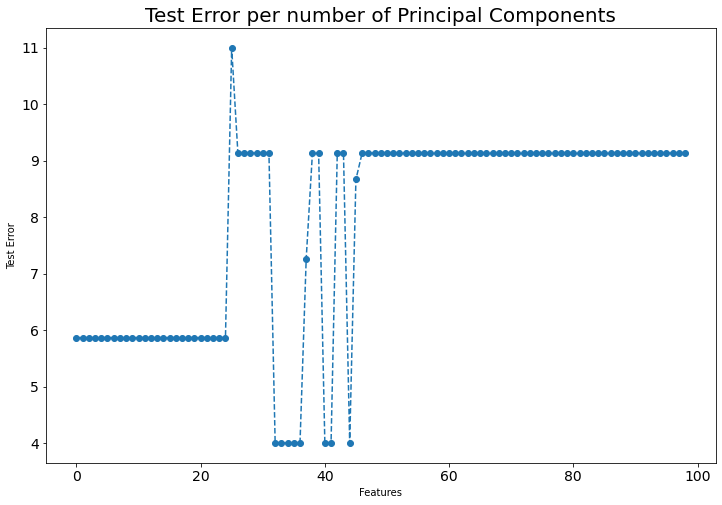

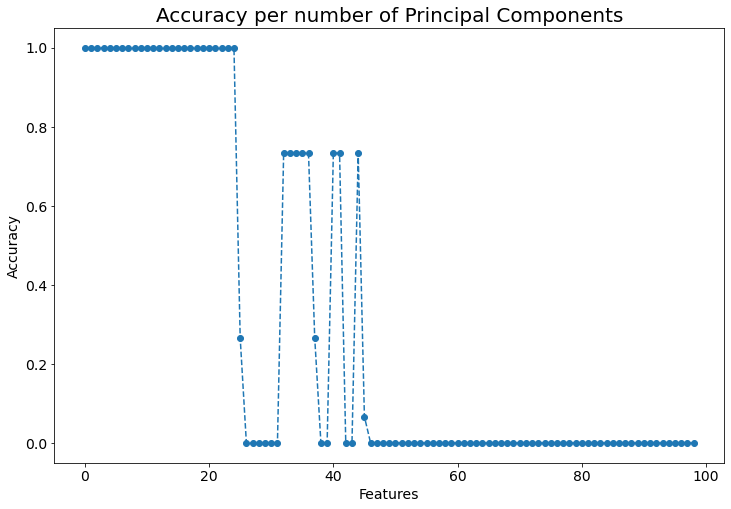


***Logistic Regression with PCA***
Best value of r for Logistic Regression with PCA =  76
Minimum value of error for Logistic Regression with PCA =  4.0
Accuracy of Logistic Regression with PCA =  1.0


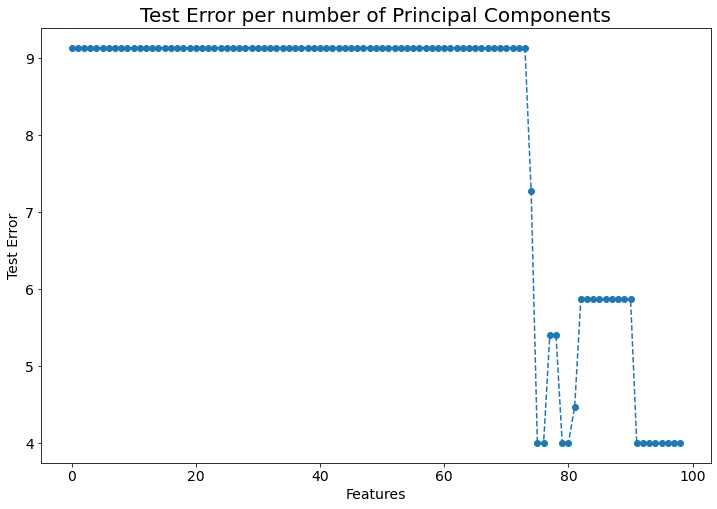

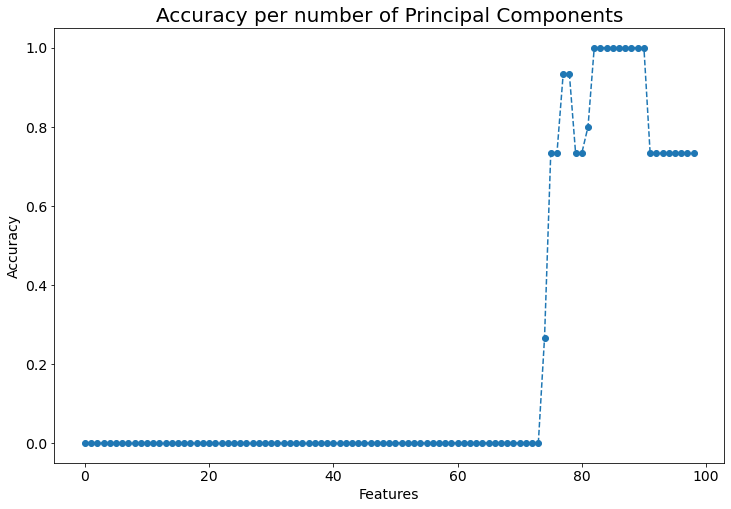

In [10]:
##GDA with PCA
r1, test_error1, accuracy1 = select_rank_r(X_train1, y_train1, X_test1, y_test1, method='GDA')
print("\n***GDA with PCA***")
print('Best value of r for GDA with PCA = ', r1)
print('Minimum value of error for GDA with PCA = ', min(test_error1))
print('Accuracy of GDA with PCA = ', max(accuracy1))
plot_figure(test_error1, accuracy1)

##Logistic Regression with PCA
r2, test_error2, accuracy2 = select_rank_r(X_train1, y_train1, X_test1, y_test1, method='Logistic')
print("\n***Logistic Regression with PCA***")
print('Best value of r for Logistic Regression with PCA = ', r2)
print('Minimum value of error for Logistic Regression with PCA = ', min(test_error2))
print('Accuracy of Logistic Regression with PCA = ', max(accuracy2))
plot_figure(test_error2, accuracy2)

In [14]:
##Question-1
#Generating simulated data - 2
"""
simulated data with evals = diag([100 * np.random.randn(d, 1)^2])
"""
evals2 = np.diag((100 * np.random.randn(d, 1) ** 2))

X2, y2, cov_sigma = generate_data_GDA(n, d, phi, mu_0, mu_1, tmp, evals2)
#print(X1.shape, y1.shape)

X_train2 = X1[0:25, 0:d]
y_train2 = y1[0:25]
X_test2 = X1[25:n, 0:d]
y_test2 = y1[25:n]

print("***Simulated Data for evals = diag([100 * np.random.randn(d, 1)^2])***")
#print('Theta = ', theta)
#print('Mean (mu_x) = ', mu_x)
print('X Shape : ', X2.shape)
print('y Shape : ', y2.shape)
print('X_train Shape : ', X_train2.shape)
print('y_train Shape : ', y_train2.shape)
print('X_test Shape : ', X_test2.shape)
print('y_test Shape : ', y_test2.shape)

***Simulated Data for evals = diag([100 * np.random.randn(d, 1)^2])***
X Shape :  (40, 100)
y Shape :  (40, 1)
X_train Shape :  (25, 100)
y_train Shape :  (25, 1)
X_test Shape :  (15, 100)
y_test Shape :  (15, 1)


In [15]:
##Making sure class mean of mu-0 is sufficiently far from class of mu_1
trace_sigma = np.trace(cov_sigma)
#print(trace_sigma)

l2_mu = np.sqrt(np.sum(np.square(mu_0 - mu_1)))
#print(l2_mu)

if l2_mu > 9*trace_sigma:
    print("Mean for Class-0 (mu_0) is sufficiently far from Mean for Class-1 (mu_1)")

Mean for Class-0 (mu_0) is sufficiently far from Mean for Class-1 (mu_1)


In [16]:
##GDA estimation without PCA
estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma = estimate_GDA(X1, y1)
y_hat_gda = prediction_GDA(X_test2, y_test2, estimate_phi, estimate_mu_0, estimate_mu_1, estimate_sigma)
error_metric_gda = error_estimate(y_test2, y_hat_gda)
accuracy_gda = accuracy_score(y_test2, y_hat_gda)
print("\n***GDA without PCA***")
print('Error for GDA without PCA = ', error_metric_gda)
print('Accuracy of GDA without PCA = ', accuracy_gda)

##Logistic Regression without PCA
y_hat_lr = log_reg(X2, y2, X_test2, y_test2, max_iter, alpha)
error_metric_lr = error_estimate(y_test2, y_hat_lr)
accuracy_lr = accuracy_score(y_test2, y_hat_lr)
print("\n***Logistic Regression without PCA***")
print('Error for Logistic Regression without PCA = ', error_metric_lr)
print('Accuracy of Logistic Regression without PCA = ', accuracy_lr)


***GDA without PCA***
Error for GDA without PCA =  5.866666666666666
Accuracy of GDA without PCA =  1.0

***Logistic Regression without PCA***
Error for Logistic Regression without PCA =  5.866666666666666
Accuracy of Logistic Regression without PCA =  1.0



***GDA with PCA***
Best value of r for GDA with PCA =  33
Minimum value of error for GDA with PCA =  4.0
Accuracy of GDA with PCA =  1.0


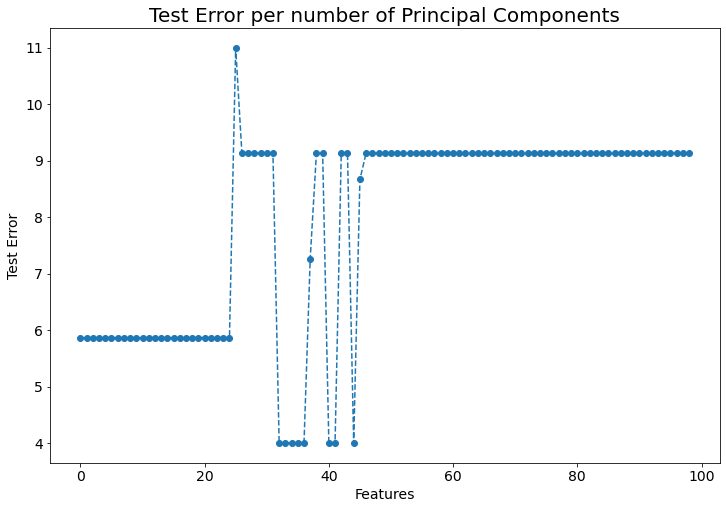

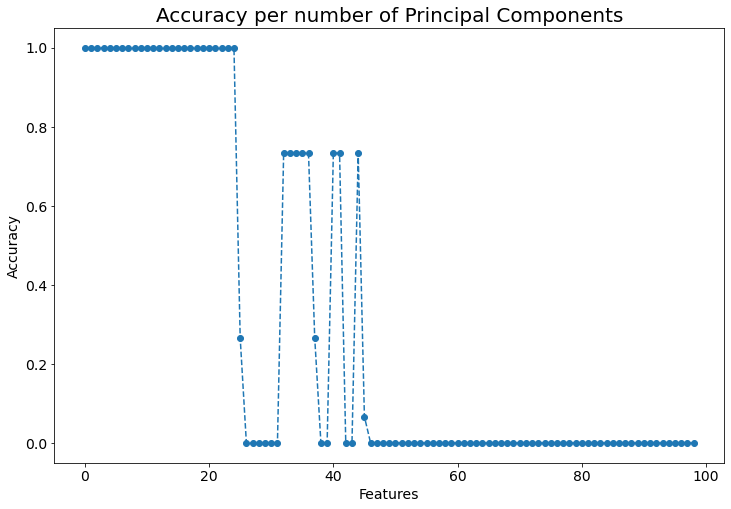


***Logistic Regression with PCA***
Best value of r for Logistic Regression with PCA =  76
Minimum value of error for Logistic Regression with PCA =  4.0
Accuracy of Logistic Regression with PCA =  1.0


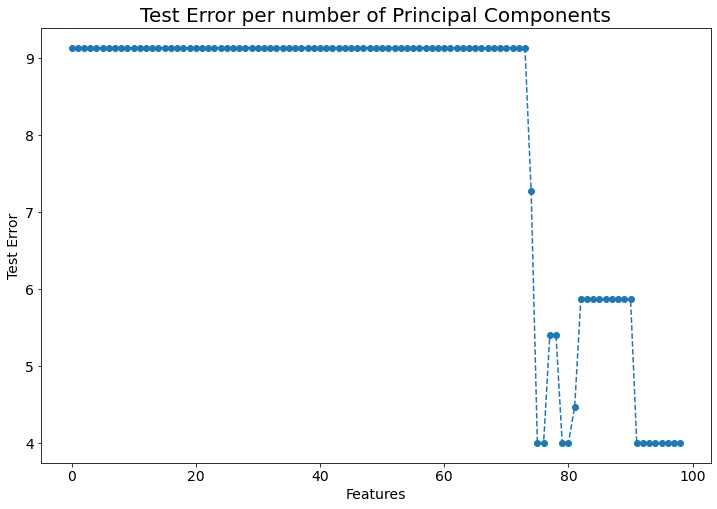

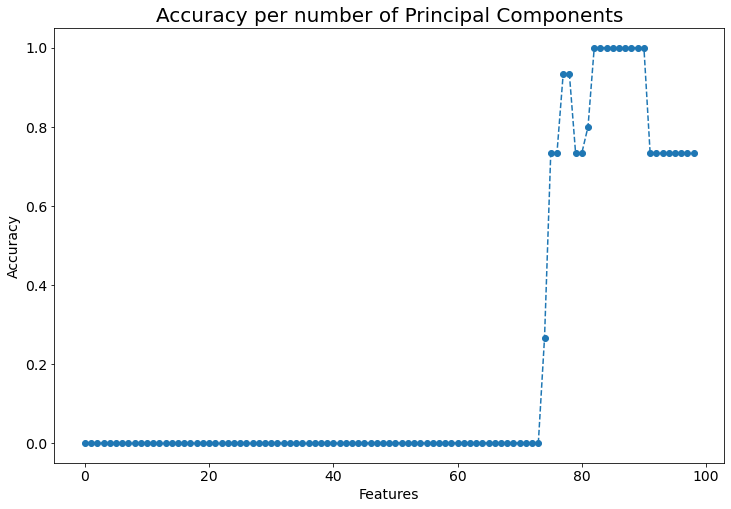

In [17]:
##GDA with PCA
r1, test_error1, accuracy1 = select_rank_r(X_train2, y_train2, X_test2, y_test2, method='GDA')
print("\n***GDA with PCA***")
print('Best value of r for GDA with PCA = ', r1)
print('Minimum value of error for GDA with PCA = ', min(test_error1))
print('Accuracy of GDA with PCA = ', max(accuracy1))
plot_figure(test_error1, accuracy1)

##Logistic Regression with PCA
r2, test_error2, accuracy2 = select_rank_r(X_train2, y_train2, X_test2, y_test2, method='Logistic')
print("\n***Logistic Regression with PCA***")
print('Best value of r for Logistic Regression with PCA = ', r2)
print('Minimum value of error for Logistic Regression with PCA = ', min(test_error2))
print('Accuracy of Logistic Regression with PCA = ', max(accuracy2))
plot_figure(test_error2, accuracy2)

In [12]:
##Importing MNIST Data
print("\n***MNIST DATA***\n")
train_raw = pd.read_csv(r'C:\Users\soura\Box\Spring 2022\EE 425\Assignments\HW-4\mnist\mnist_train.csv')
test_raw = pd.read_csv(r'C:\Users\soura\Box\Spring 2022\EE 425\Assignments\HW-4\mnist\mnist_test.csv')
train_raw.shape
test_raw.shape

train_data = train_raw.drop('label',axis=1)
train_data = train_raw.iloc[:, 1:]
train_label = train_raw['label']
#train_label = train_raw.loc[:, 'label']
print('Training Data Shape : ', train_data.shape)
print('Training label Shape : ', train_label.shape)

test_data = test_raw.drop('label',axis=1)
test_data = test_raw.iloc[:, 1:]
test_label = test_raw['label']
#test_label = test_raw.loc[:, 'label']

print('Testing Data Shape : ', test_data.shape)
print('Testing label Shape : ', test_label.shape)

X_train = train_data[np.logical_or(train_label==9, train_label==0)]
y_train = train_label[np.logical_or(train_label==9, train_label==0)]
X_test = test_data[np.logical_or(test_label==9, test_label==0)]
y_test = test_label[np.logical_or(test_label==9, test_label==0)]

print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)


***MNIST DATA***

Training Data Shape :  (60000, 784)
Training label Shape :  (60000,)
Testing Data Shape :  (10000, 784)
Testing label Shape :  (10000,)
X_train shape : (11872, 784)
y_train shape : (11872,)
X_test shape : (1989, 784)
y_test shape : (1989,)


In [13]:
##GDA - MNIST
def gda_mnist(X_train, y_train, X_test, y_test):
    gda_model = LinearDiscriminantAnalysis(solver='svd').fit(X_train, y_train)
    y_pred = gda_model.predict(X_test)
    
    return y_pred

In [14]:
def log_reg_mnist(X_train, y_train, X_test, y_test):
    ##Logistic Regression
    lr_model = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    
    return y_pred

In [15]:
def select_rank_r_mnist(X, y, X_test, y_test, method):
    """
    return an optimal rank of the approximation matrix based on the test MSE and a plot of test MSE against the number of features
    return: r is the optimal rank of the approximation matrix
    """
    if X.shape[0] != y.shape[0]:
        raise Exception("X and y must have the same dimension")
    elif X_test.shape[0] != y_test.shape[0]:
        raise Exception("X_test and y_test must have the same dimension")
    max_iter = 1000
    alpha = 1e-2
    m = X.shape[0]
    n = X.shape[1]
    one_mat = np.ones((n,1))
    #print(one_mat.shape)
    #mu_hat = np.sum(X) / X.shape[0]
    mu_hat = X.mean(axis=0)
    #print(mu_hat.shape)
    Z = X - np.dot(mu_hat.T, one_mat)
    #print(Z.shape)
    U_full, S_full, V_full = np.linalg.svd(Z)

    test_error = []
    accuracy = []
    for i in range(1, X.shape[1]):
        V = np.transpose(V_full)[:, 0:i]
        B = np.dot(X, V)
        #print(B.shape)
        #adding mean term
        c_hat = np.ones(B.shape[0]).reshape(B.shape[0], 1)
        B = np.concatenate((c_hat, B), axis=1)
        #print('B = ', B.shape)
        if method == 'GDA':
            y_hat = gda_mnist(B[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test)
            accuracy.append(accuracy_score(y_test, y_hat))
            
        if method == 'Logistic':
            #y_hat = estimate_logistic_reg(B[:, 0:(i+1)], y_test, max_iter, alpha)
            y_hat = log_reg_mnist(B[:, 0:(i+1)], y, X_test[:, 0:(i+1)], y_test)
            accuracy.append(accuracy_score(y_test, y_hat))
            
        error_metric = error_estimate(y_test, y_hat)
        #print(error_metric)
        test_error.append(error_metric)

    r = np.argmin(test_error) + 1
    #plot_content = (np.arange(0, len(test_mse), 1), np.log(test_mse))

    return r, test_error, accuracy

In [18]:
##GDA with PCA
r3, test_error3, accuracy3 = select_rank_r_mnist(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), method='GDA')

print("\n***GDA with PCA***")
print('Best value of r for GDA with PCA = ', r3)
print('Minimum value of error for GDA with PCA = ', min(test_error3))
print('Accuracy of GDA with PCA = ', max(accuracy3))
#plot_figure(test_error1, accuracy1)


***GDA with PCA***
Best value of r for GDA with PCA =  463
Minimum value of error for GDA with PCA =  0.8371040723981901
Accuracy of GDA with PCA =  0.9069884364002011


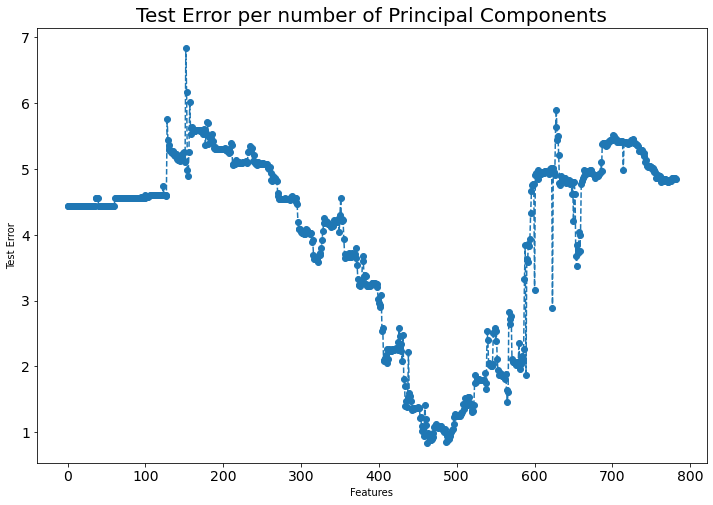

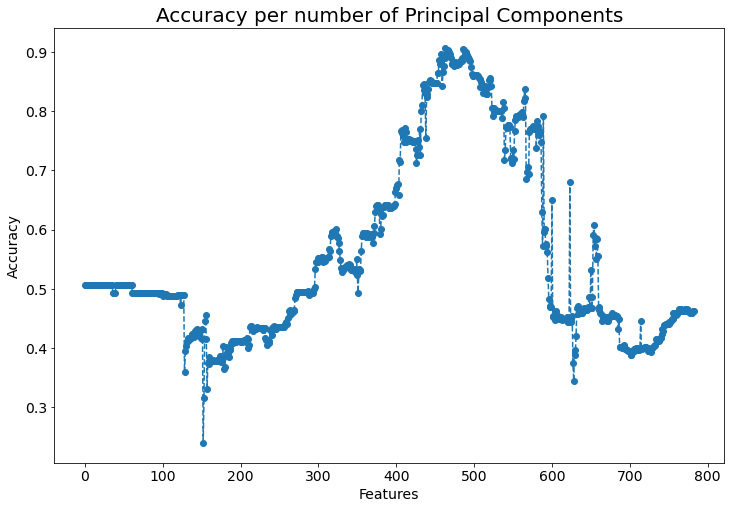

In [21]:
plot_figure(test_error3, accuracy3)

In [20]:
##Logistic Regression with PCA
r4, test_error4, accuracy4 = select_rank_r_mnist(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), method='Logistic')
print("\n***Logistic Regression with PCA***")
print('Best value of r for Logistic Regression with PCA = ', r4)
print('Minimum value of error for Logistic Regression with PCA = ', min(test_error4))
print('Accuracy of Logistic Regression with PCA = ', max(accuracy4))
#plot_figure(test_error2)


***Logistic Regression with PCA***
Best value of r for Logistic Regression with PCA =  152
Minimum value of error for Logistic Regression with PCA =  2.244343891402715
Accuracy of Logistic Regression with PCA =  0.7506284565108094


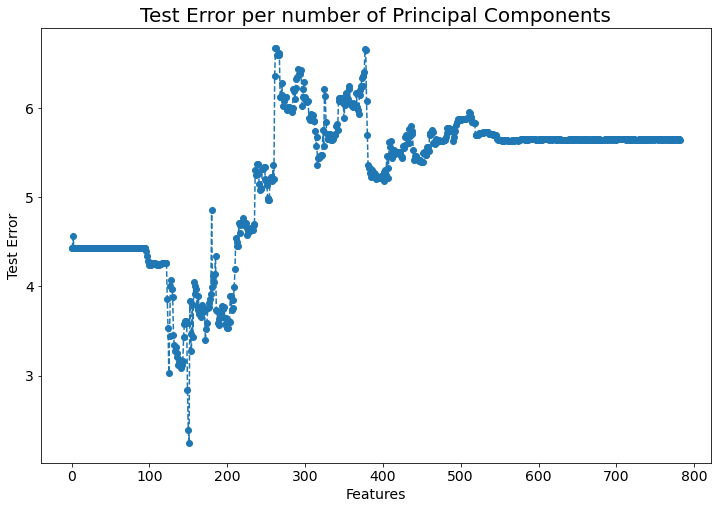

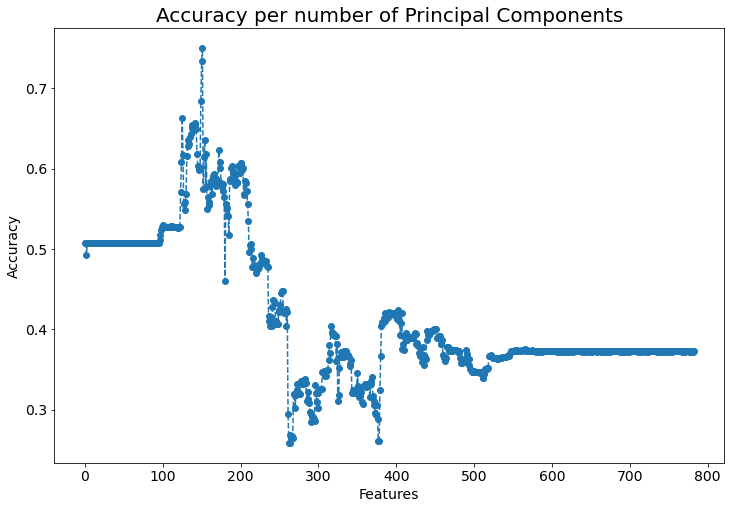

In [22]:
plot_figure(test_error4, accuracy4)